In [1]:
from pymoo.problems.many.dtlz import DTLZ2
from pymoo.util.ref_dirs import get_reference_directions
import pandas as pd
from pymoo.util.dominator import Dominator
from pymoo.indicators.hv import Hypervolume
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C , WhiteKernel
from pymoo.operators.sampling.lhs import LHS
import matplotlib.pyplot as plt
from pymoo.indicators.hv import HV
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.display.output import Output, pareto_front_if_possible
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import numpy as np
import random

#### Number of objectives = 2 , Number of decision variables = 2 , Number of samples = 20(10 x 2)

In [2]:
weight_vectors = get_reference_directions('energy',2,20)

In [3]:
problem = DTLZ2(n_obj=2,n_var=2)
sampling  = LHS()
ref_dirs = sampling(problem,20).get('X')

In [4]:
pareto_front = problem.pareto_front()
hypervolume_pf = Hypervolume(pf= pareto_front,norm_ref_point=False).do(pareto_front)
print('Hypervolume of PF is {0} '.format(hypervolume_pf))

[1. 1.]
Hypervolume of PF is 0.2101303514688242 


In [5]:
output = {}
problem._evaluate(ref_dirs,output)

In [6]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
columns = []
for i in range(1,3):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2']


In [7]:
dataset.head()

,x1,x2,Objective 1,Objective 2
0,0.033888,0.014720,1.233746,0.065737
1,0.877134,0.123473,0.218994,1.120574
2,0.712933,0.358535,0.444518,0.918057
3,0.821605,0.627740,0.281083,0.976675
4,0.205927,0.289686,0.990076,0.331918


##### MOdelling on Objective 1

In [8]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [9]:
kernel_2 = C(4.0) * RBF(length_scale=0.1) + WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Model on Objective 2

In [10]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [11]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=4,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i]])
        out["F"] = objective_values

In [12]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,mean]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i]])
        out["F"] = objective_values

In [13]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm_1,algorithm_2):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm_1,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm_2,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [14]:
# non dominated sorting

def fast_non_dominated_sort(F, **kwargs):
    
    M = Dominator.calc_domination_matrix(F)

    # calculate the dominance matrix
    n = M.shape[0]

    fronts = []

    if n == 0:
        return fronts

    # final rank that will be returned
    n_ranked = 0
    ranked = np.zeros(n, dtype=int)

    # for each individual a list of all individuals that are dominated by this one
    is_dominating = [[] for _ in range(n)]

    # storage for the number of solutions dominated this one
    n_dominated = np.zeros(n)

    current_front = []

    for i in range(n):

        for j in range(i + 1, n):
            rel = M[i, j]
            if rel == 1:
                is_dominating[i].append(j)
                n_dominated[j] += 1
            elif rel == -1:
                is_dominating[j].append(i)
                n_dominated[i] += 1

        if n_dominated[i] == 0:
            current_front.append(i)
            ranked[i] = 1.0
            n_ranked += 1

    # append the first front to the current front
    fronts.append(current_front)

    # while not all solutions are assigned to a pareto front
    while n_ranked < n:

        next_front = []

        # for each individual in the current front
        for i in current_front:

            # all solutions that are dominated by this individuals
            for j in is_dominating[i]:
                n_dominated[j] -= 1
                if n_dominated[j] == 0:
                    next_front.append(j)
                    ranked[j] = 1.0
                    n_ranked += 1

        fronts.append(next_front)
        current_front = next_front

    return fronts

In [15]:
def optimize_problem(algorithm_1,algorithm_2, problem_1,problem_2):
    data = []
    initial_output = {}
    Hypervolume  = []
    new_ref_dirs = ref_dirs
    problem._evaluate(ref_dirs,initial_output)
    initial_objectives = initial_output['F']
    initial_ref_vec  = [1.0,1.0]
    initial_non_dominated_front = fast_non_dominated_sort(initial_objectives)
    initial_ind = HV(ref_point=initial_ref_vec)
    print('Iteration 0 initial Hypervolume is {0}'.format(initial_ind(initial_objectives[initial_non_dominated_front[0]])))
    Hypervolume.append(initial_ind(initial_objectives[initial_non_dominated_front[0]]))
    for i in range(50):
        data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm_1,algorithm_2))
        new_data = list(new_ref_dirs) + data
        new_ref_dirs = list(new_ref_dirs) + data
        new_data = np.array(new_data)
        output = {}
        new_objectives  = problem._evaluate(new_data,output)
        new_dataset = pd.DataFrame(data = new_data,columns = columns)
        new_obj1 = [i[0] for i in output['F']]
        new_obj2 = [i[1] for i in output['F']]
        new_dataset['Objective 1']  = new_obj1
        new_dataset['Objective 2'] = new_obj2
        objectives_new = []
        objectives1_new = list(new_dataset['Objective 1'])
        objectives2_new = list(new_dataset['Objective 2'])
        for j in range(len(new_dataset['Objective 1'])):
            objectives_new.append([objectives1_new[j],objectives2_new[j]])
        #print('Calculating Front')
        fronts_new = fast_non_dominated_sort(np.array(objectives_new))
        ref_vector  = [1.0,1.0] #[max(objectives1_new),max(objectives2_new)]
        objectives  = np.array(objectives_new)
        #print('Calculating Hypervolumne',objectives[fronts_new[0]])
        ind = HV(ref_point=ref_vector)
        Hypervolume.append(ind(objectives[fronts_new[0]]))
        print('Iteration : {0} Hypervolume of Non Dominated Front is {1}'.format(i+1,ind(objectives[fronts_new[0]])))
    Hypervolume_increase = [i/hypervolume_pf for i in Hypervolume]
    plt.plot(list(range(1,52)),Hypervolume_increase)
    plt.title('Hypervolume Increase in 50 Generations')
    plt.show()
    return [new_dataset,Hypervolume_increase]


In [16]:
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm_2 = NSGA2(pop_size = 100)
algorithm_2_2 = MOEAD(ref_dirs=weight_vectors)
algorithm_3_2 = NSGA3(ref_dirs=weight_vectors)

weight_vectors_1 = get_reference_directions('energy',4,20)
algorithm_1 = NSGA2(pop_size = 100)
algorithm_2_1 = MOEAD(ref_dirs=weight_vectors_1)
algorithm_3_1 = NSGA3(ref_dirs=weight_vectors_1)


Iteration 0 initial Hypervolume is 0.14719062453487997
Iteration : 1 Hypervolume of Non Dominated Front is 0.14719062453487997
Iteration : 2 Hypervolume of Non Dominated Front is 0.14719062453487997
Iteration : 3 Hypervolume of Non Dominated Front is 0.14719062453487997
Iteration : 4 Hypervolume of Non Dominated Front is 0.1474151890456477
Iteration : 5 Hypervolume of Non Dominated Front is 0.1474151890456477
Iteration : 6 Hypervolume of Non Dominated Front is 0.1474151890456477
Iteration : 7 Hypervolume of Non Dominated Front is 0.1474151890456477
Iteration : 8 Hypervolume of Non Dominated Front is 0.1474151890456477
Iteration : 9 Hypervolume of Non Dominated Front is 0.14859896753341656
Iteration : 10 Hypervolume of Non Dominated Front is 0.14916313040444715
Iteration : 11 Hypervolume of Non Dominated Front is 0.15432454708698023
Iteration : 12 Hypervolume of Non Dominated Front is 0.15432454708698023
Iteration : 13 Hypervolume of Non Dominated Front is 0.1571813811528987
Iteration :

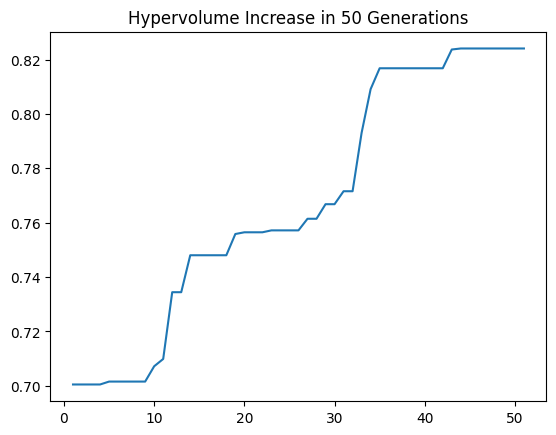

1295

In [17]:
new_dataset,Hypervolume_increse_NSGA = optimize_problem(algorithm_1,algorithm_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.14719062453487997
Iteration : 1 Hypervolume of Non Dominated Front is 0.1472308058241538
Iteration : 2 Hypervolume of Non Dominated Front is 0.14775866206373117
Iteration : 3 Hypervolume of Non Dominated Front is 0.15507340843455417
Iteration : 4 Hypervolume of Non Dominated Front is 0.15507393220077054
Iteration : 5 Hypervolume of Non Dominated Front is 0.15507393220077054
Iteration : 6 Hypervolume of Non Dominated Front is 0.15507393220077054
Iteration : 7 Hypervolume of Non Dominated Front is 0.16645705481574885
Iteration : 8 Hypervolume of Non Dominated Front is 0.1686423728006103
Iteration : 9 Hypervolume of Non Dominated Front is 0.16874456375037386
Iteration : 10 Hypervolume of Non Dominated Front is 0.16874456375037386
Iteration : 11 Hypervolume of Non Dominated Front is 0.1690935177373094
Iteration : 12 Hypervolume of Non Dominated Front is 0.1690935177373094
Iteration : 13 Hypervolume of Non Dominated Front is 0.17187506807987893
Iteration

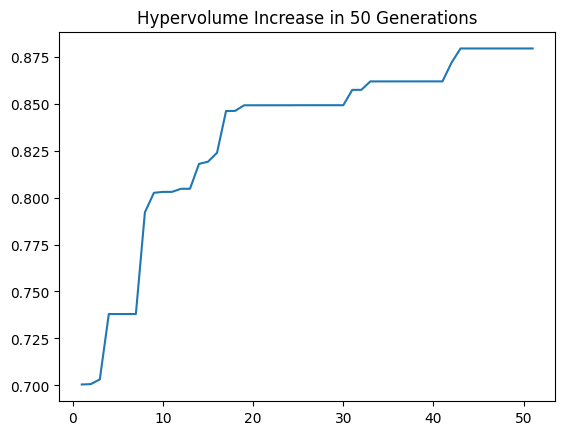

1295

In [18]:
new_dataset,Hypervolume_increse_MOEAD = optimize_problem(algorithm_2_1,algorithm_2_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.14719062453487997
Iteration : 1 Hypervolume of Non Dominated Front is 0.14719062453487997
Iteration : 2 Hypervolume of Non Dominated Front is 0.14719062453487997
Iteration : 3 Hypervolume of Non Dominated Front is 0.14719062453487997
Iteration : 4 Hypervolume of Non Dominated Front is 0.14719062453487997
Iteration : 5 Hypervolume of Non Dominated Front is 0.14880568578142123
Iteration : 6 Hypervolume of Non Dominated Front is 0.15962178111640546
Iteration : 7 Hypervolume of Non Dominated Front is 0.15962178111640546
Iteration : 8 Hypervolume of Non Dominated Front is 0.15962178111640546
Iteration : 9 Hypervolume of Non Dominated Front is 0.16431424600006253
Iteration : 10 Hypervolume of Non Dominated Front is 0.1713434960448608
Iteration : 11 Hypervolume of Non Dominated Front is 0.1713434960448608
Iteration : 12 Hypervolume of Non Dominated Front is 0.1713434960448608
Iteration : 13 Hypervolume of Non Dominated Front is 0.1713434960448608
Iteration

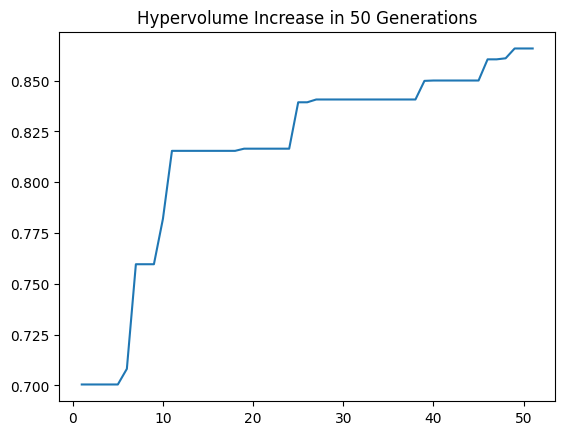

1295

In [19]:
new_dataset,Hypervolume_increse_NSGA3 = optimize_problem(algorithm_3_1,algorithm_3_2,problem_1,problem_2)
len(new_dataset)


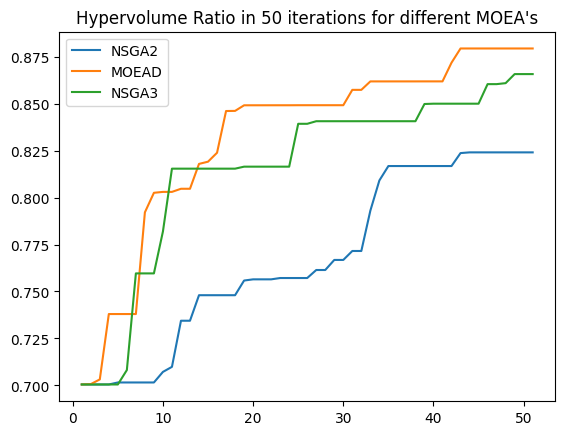

In [20]:
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA,label="NSGA2")
plt.plot(list(range(1,52)),Hypervolume_increse_MOEAD,label="MOEAD")
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA3,label="NSGA3")
plt.title("Hypervolume Ratio in 50 iterations for different MOEA's")
plt.legend()
plt.show()



#### DTLZ2 nobj = 2 , nvars = 3

In [58]:
weight_vectors = get_reference_directions('energy',2,30)

In [59]:
problem = DTLZ2(n_obj=2,n_var=3)
sampling  = LHS()
ref_dirs = sampling(problem,30).get('X')

In [60]:
pareto_front = problem.pareto_front()
hypervolume_pf = Hypervolume(pf= pareto_front,norm_ref_point=False).do(pareto_front)
print('Hypervolume of PF is {0} '.format(hypervolume_pf))

[1. 1.]
Hypervolume of PF is 0.2101303514688242 


In [61]:
output = {}
problem._evaluate(ref_dirs,output)

In [62]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
columns = []
for i in range(1,4):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2', 'x3']


In [63]:
dataset.head()

,x1,x2,x3,Objective 1,Objective 2
0,0.605148,0.646767,0.830083,0.657070,0.919934
1,0.108195,0.825865,0.506581,1.090294,0.187103
2,0.806637,0.242346,0.422157,0.320752,1.023356
3,0.788256,0.349639,0.122339,0.380460,1.101375
4,0.211880,0.226430,0.335831,1.041331,0.359966


##### MOdelling on Objective 1

In [64]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [65]:
kernel_2 = C(4.0) * RBF(length_scale=0.1) + WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

#### Model on Objective 2

In [66]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [67]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=3, n_obj=4,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i]])
        out["F"] = objective_values

In [68]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=3, n_obj=2,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,mean]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i]])
        out["F"] = objective_values

In [69]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm_1,algorithm_2):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm_1,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm_2,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [70]:
# non dominated sorting

def fast_non_dominated_sort(F, **kwargs):
    
    M = Dominator.calc_domination_matrix(F)

    # calculate the dominance matrix
    n = M.shape[0]

    fronts = []

    if n == 0:
        return fronts

    # final rank that will be returned
    n_ranked = 0
    ranked = np.zeros(n, dtype=int)

    # for each individual a list of all individuals that are dominated by this one
    is_dominating = [[] for _ in range(n)]

    # storage for the number of solutions dominated this one
    n_dominated = np.zeros(n)

    current_front = []

    for i in range(n):

        for j in range(i + 1, n):
            rel = M[i, j]
            if rel == 1:
                is_dominating[i].append(j)
                n_dominated[j] += 1
            elif rel == -1:
                is_dominating[j].append(i)
                n_dominated[i] += 1

        if n_dominated[i] == 0:
            current_front.append(i)
            ranked[i] = 1.0
            n_ranked += 1

    # append the first front to the current front
    fronts.append(current_front)

    # while not all solutions are assigned to a pareto front
    while n_ranked < n:

        next_front = []

        # for each individual in the current front
        for i in current_front:

            # all solutions that are dominated by this individuals
            for j in is_dominating[i]:
                n_dominated[j] -= 1
                if n_dominated[j] == 0:
                    next_front.append(j)
                    ranked[j] = 1.0
                    n_ranked += 1

        fronts.append(next_front)
        current_front = next_front

    return fronts

In [71]:
def optimize_problem(algorithm_1,algorithm_2, problem_1,problem_2):
    data = []
    initial_output = {}
    Hypervolume  = []
    new_ref_dirs = ref_dirs
    problem._evaluate(ref_dirs,initial_output)
    initial_objectives = initial_output['F']
    initial_ref_vec  = [1.0,1.0]
    initial_non_dominated_front = fast_non_dominated_sort(initial_objectives)
    initial_ind = HV(ref_point=initial_ref_vec)
    print('Iteration 0 initial Hypervolume is {0}'.format(initial_ind(initial_objectives[initial_non_dominated_front[0]])))
    Hypervolume.append(initial_ind(initial_objectives[initial_non_dominated_front[0]]))
    for i in range(50):
        data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm_1,algorithm_2))
        new_data = list(new_ref_dirs) + data
        new_ref_dirs = list(new_ref_dirs) + data
        new_data = np.array(new_data)
        output = {}
        new_objectives  = problem._evaluate(new_data,output)
        new_dataset = pd.DataFrame(data = new_data,columns = columns)
        new_obj1 = [i[0] for i in output['F']]
        new_obj2 = [i[1] for i in output['F']]
        new_dataset['Objective 1']  = new_obj1
        new_dataset['Objective 2'] = new_obj2
        objectives_new = []
        objectives1_new = list(new_dataset['Objective 1'])
        objectives2_new = list(new_dataset['Objective 2'])
        for j in range(len(new_dataset['Objective 1'])):
            objectives_new.append([objectives1_new[j],objectives2_new[j]])
        #print('Calculating Front')
        fronts_new = fast_non_dominated_sort(np.array(objectives_new))
        ref_vector  = [1.0,1.0] #[max(objectives1_new),max(objectives2_new)]
        objectives  = np.array(objectives_new)
        #print('Calculating Hypervolumne',objectives[fronts_new[0]])
        ind = HV(ref_point=ref_vector)
        Hypervolume.append(ind(objectives[fronts_new[0]]))
        print('Iteration : {0} Hypervolume of Non Dominated Front is {1}'.format(i+1,ind(objectives[fronts_new[0]])))
    Hypervolume_increase = [i/hypervolume_pf for i in Hypervolume]
    plt.plot(list(range(1,52)),Hypervolume_increase)
    plt.title('Hypervolume Increase in 50 Generations')
    plt.show()
    return [new_dataset,Hypervolume_increase]


In [72]:
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm_2 = NSGA2(pop_size = 100)
algorithm_2_2 = MOEAD(ref_dirs=weight_vectors)
algorithm_3_2 = NSGA3(ref_dirs=weight_vectors)

weight_vectors_1 = get_reference_directions('energy',4,30)
algorithm_1 = NSGA2(pop_size = 100)
algorithm_2_1 = MOEAD(ref_dirs=weight_vectors_1)
algorithm_3_1 = NSGA3(ref_dirs=weight_vectors_1)


Iteration 0 initial Hypervolume is 0.1189410307649872
Iteration : 1 Hypervolume of Non Dominated Front is 0.11990544166492804
Iteration : 2 Hypervolume of Non Dominated Front is 0.11990544166492804
Iteration : 3 Hypervolume of Non Dominated Front is 0.11990544166492804
Iteration : 4 Hypervolume of Non Dominated Front is 0.1222823140999845
Iteration : 5 Hypervolume of Non Dominated Front is 0.1222823140999845
Iteration : 6 Hypervolume of Non Dominated Front is 0.1222823140999845
Iteration : 7 Hypervolume of Non Dominated Front is 0.1222823140999845
Iteration : 8 Hypervolume of Non Dominated Front is 0.1222823140999845
Iteration : 9 Hypervolume of Non Dominated Front is 0.1222823140999845
Iteration : 10 Hypervolume of Non Dominated Front is 0.1222823140999845
Iteration : 11 Hypervolume of Non Dominated Front is 0.12563400314994058
Iteration : 12 Hypervolume of Non Dominated Front is 0.12563400314994058
Iteration : 13 Hypervolume of Non Dominated Front is 0.12563400314994058
Iteration : 1

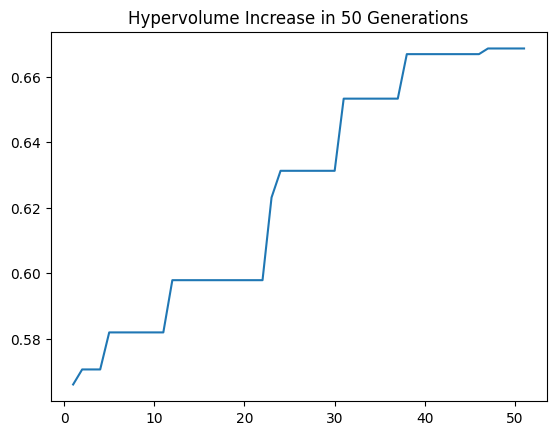

1305

In [73]:
new_dataset,Hypervolume_increse_NSGA = optimize_problem(algorithm_1,algorithm_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.1189410307649872
Iteration : 1 Hypervolume of Non Dominated Front is 0.1189410307649872
Iteration : 2 Hypervolume of Non Dominated Front is 0.1189410307649872
Iteration : 3 Hypervolume of Non Dominated Front is 0.1189410307649872
Iteration : 4 Hypervolume of Non Dominated Front is 0.11918636089084336
Iteration : 5 Hypervolume of Non Dominated Front is 0.11918636089084336
Iteration : 6 Hypervolume of Non Dominated Front is 0.12164226705271337
Iteration : 7 Hypervolume of Non Dominated Front is 0.12164226705271337
Iteration : 8 Hypervolume of Non Dominated Front is 0.12164226705271337
Iteration : 9 Hypervolume of Non Dominated Front is 0.1294120379303572
Iteration : 10 Hypervolume of Non Dominated Front is 0.1294153184322742
Iteration : 11 Hypervolume of Non Dominated Front is 0.1295031457125902
Iteration : 12 Hypervolume of Non Dominated Front is 0.1295031457125902
Iteration : 13 Hypervolume of Non Dominated Front is 0.1295135008076409
Iteration : 14

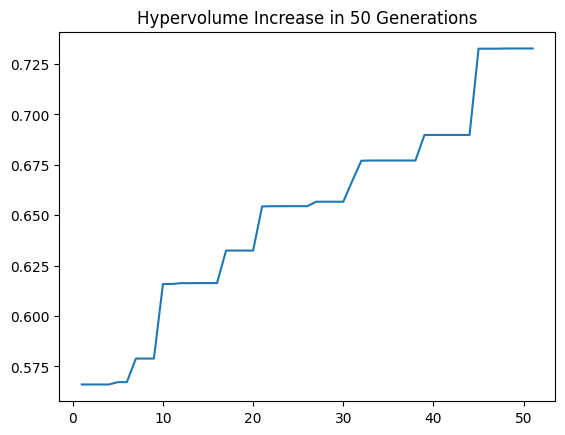

1305

In [74]:
new_dataset,Hypervolume_increse_MOEAD = optimize_problem(algorithm_2_1,algorithm_2_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.1189410307649872
Iteration : 1 Hypervolume of Non Dominated Front is 0.1189410307649872
Iteration : 2 Hypervolume of Non Dominated Front is 0.1189410307649872
Iteration : 3 Hypervolume of Non Dominated Front is 0.1189410307649872
Iteration : 4 Hypervolume of Non Dominated Front is 0.1189410307649872
Iteration : 5 Hypervolume of Non Dominated Front is 0.1189410307649872
Iteration : 6 Hypervolume of Non Dominated Front is 0.12218024594736218
Iteration : 7 Hypervolume of Non Dominated Front is 0.12218024594736218
Iteration : 8 Hypervolume of Non Dominated Front is 0.12218024594736218
Iteration : 9 Hypervolume of Non Dominated Front is 0.12218024594736218
Iteration : 10 Hypervolume of Non Dominated Front is 0.12218024594736218
Iteration : 11 Hypervolume of Non Dominated Front is 0.12218024594736218
Iteration : 12 Hypervolume of Non Dominated Front is 0.12218024594736218
Iteration : 13 Hypervolume of Non Dominated Front is 0.12218024594736218
Iteration :

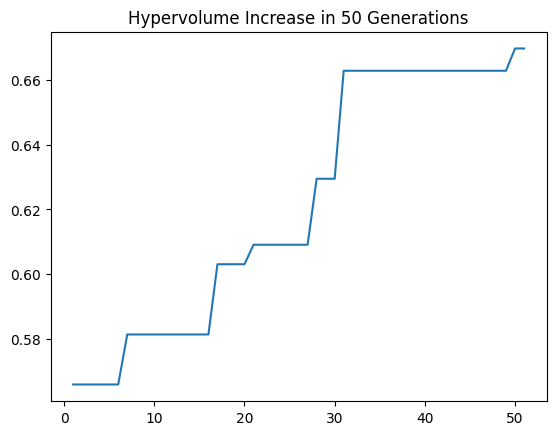

1305

In [75]:
new_dataset,Hypervolume_increse_NSGA3 = optimize_problem(algorithm_3_1,algorithm_3_2,problem_1,problem_2)
len(new_dataset)


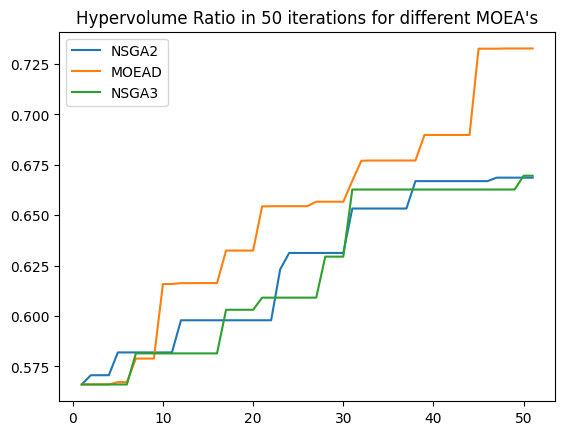

In [76]:
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA,label="NSGA2")
plt.plot(list(range(1,52)),Hypervolume_increse_MOEAD,label="MOEAD")
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA3,label="NSGA3")
plt.title("Hypervolume Ratio in 50 iterations for different MOEA's")
plt.legend()
plt.show()



#### DTLZ2 nobj = 2 nvars = 5

In [77]:
weight_vectors = get_reference_directions('energy',2,50)

In [78]:
problem = DTLZ2(n_obj=2,n_var=5)
sampling  = LHS()
ref_dirs = sampling(problem,50).get('X')

In [79]:
pareto_front = problem.pareto_front()
hypervolume_pf = Hypervolume(pf= pareto_front,norm_ref_point=False).do(pareto_front)
print('Hypervolume of PF is {0} '.format(hypervolume_pf))

[1. 1.]
Hypervolume of PF is 0.2101303514688242 


In [80]:
output = {}
problem._evaluate(ref_dirs,output)

In [81]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
columns = []
for i in range(1,6):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2', 'x3', 'x4', 'x5']


In [82]:
dataset.head()

,x1,x2,x3,x4,x5,Objective 1,Objective 2
0,0.543976,0.884985,0.258741,0.819607,0.663259,0.876726,1.007060
1,0.724807,0.168764,0.880710,0.102062,0.857507,0.645505,1.399093
2,0.426494,0.567038,0.464641,0.097282,0.919683,1.053558,0.834574
3,0.642494,0.093844,0.439118,0.042415,0.616681,0.741083,1.177937
4,0.867863,0.625954,0.832393,0.843401,0.701834,0.264806,1.257430


##### MOdelling on Objective 1

In [83]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [84]:
kernel_2 = C(4.0) * RBF(length_scale=0.1) + WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

#### Model on Objective 2

In [85]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [86]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=5, n_obj=4,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i]])
        out["F"] = objective_values

In [87]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=5, n_obj=2,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,mean]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i]])
        out["F"] = objective_values

In [88]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm_1,algorithm_2):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm_1,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm_2,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [89]:
# non dominated sorting

def fast_non_dominated_sort(F, **kwargs):
    
    M = Dominator.calc_domination_matrix(F)

    # calculate the dominance matrix
    n = M.shape[0]

    fronts = []

    if n == 0:
        return fronts

    # final rank that will be returned
    n_ranked = 0
    ranked = np.zeros(n, dtype=int)

    # for each individual a list of all individuals that are dominated by this one
    is_dominating = [[] for _ in range(n)]

    # storage for the number of solutions dominated this one
    n_dominated = np.zeros(n)

    current_front = []

    for i in range(n):

        for j in range(i + 1, n):
            rel = M[i, j]
            if rel == 1:
                is_dominating[i].append(j)
                n_dominated[j] += 1
            elif rel == -1:
                is_dominating[j].append(i)
                n_dominated[i] += 1

        if n_dominated[i] == 0:
            current_front.append(i)
            ranked[i] = 1.0
            n_ranked += 1

    # append the first front to the current front
    fronts.append(current_front)

    # while not all solutions are assigned to a pareto front
    while n_ranked < n:

        next_front = []

        # for each individual in the current front
        for i in current_front:

            # all solutions that are dominated by this individuals
            for j in is_dominating[i]:
                n_dominated[j] -= 1
                if n_dominated[j] == 0:
                    next_front.append(j)
                    ranked[j] = 1.0
                    n_ranked += 1

        fronts.append(next_front)
        current_front = next_front

    return fronts

In [90]:
def optimize_problem(algorithm_1,algorithm_2, problem_1,problem_2):
    data = []
    initial_output = {}
    Hypervolume  = []
    new_ref_dirs = ref_dirs
    problem._evaluate(ref_dirs,initial_output)
    initial_objectives = initial_output['F']
    initial_ref_vec  = [1.0,1.0]
    initial_non_dominated_front = fast_non_dominated_sort(initial_objectives)
    initial_ind = HV(ref_point=initial_ref_vec)
    print('Iteration 0 initial Hypervolume is {0}'.format(initial_ind(initial_objectives[initial_non_dominated_front[0]])))
    Hypervolume.append(initial_ind(initial_objectives[initial_non_dominated_front[0]]))
    for i in range(50):
        data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm_1,algorithm_2))
        new_data = list(new_ref_dirs) + data
        new_ref_dirs = list(new_ref_dirs) + data
        new_data = np.array(new_data)
        output = {}
        new_objectives  = problem._evaluate(new_data,output)
        new_dataset = pd.DataFrame(data = new_data,columns = columns)
        new_obj1 = [i[0] for i in output['F']]
        new_obj2 = [i[1] for i in output['F']]
        new_dataset['Objective 1']  = new_obj1
        new_dataset['Objective 2'] = new_obj2
        objectives_new = []
        objectives1_new = list(new_dataset['Objective 1'])
        objectives2_new = list(new_dataset['Objective 2'])
        for j in range(len(new_dataset['Objective 1'])):
            objectives_new.append([objectives1_new[j],objectives2_new[j]])
        #print('Calculating Front')
        fronts_new = fast_non_dominated_sort(np.array(objectives_new))
        ref_vector  = [1.0,1.0] #[max(objectives1_new),max(objectives2_new)]
        objectives  = np.array(objectives_new)
        #print('Calculating Hypervolumne',objectives[fronts_new[0]])
        ind = HV(ref_point=ref_vector)
        Hypervolume.append(ind(objectives[fronts_new[0]]))
        print('Iteration : {0} Hypervolume of Non Dominated Front is {1}'.format(i+1,ind(objectives[fronts_new[0]])))
    Hypervolume_increase = [i/hypervolume_pf for i in Hypervolume]
    plt.plot(list(range(1,52)),Hypervolume_increase)
    plt.title('Hypervolume Increase in 50 Generations')
    plt.show()
    return [new_dataset,Hypervolume_increase]


In [91]:
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm_2 = NSGA2(pop_size = 100)
algorithm_2_2 = MOEAD(ref_dirs=weight_vectors)
algorithm_3_2 = NSGA3(ref_dirs=weight_vectors)

weight_vectors_1 = get_reference_directions('energy',4,50)
algorithm_1 = NSGA2(pop_size = 100)
algorithm_2_1 = MOEAD(ref_dirs=weight_vectors_1)
algorithm_3_1 = NSGA3(ref_dirs=weight_vectors_1)


Iteration 0 initial Hypervolume is 0.04851075635924838
Iteration : 1 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 2 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 3 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 4 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 5 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 6 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 7 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 8 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 9 Hypervolume of Non Dominated Front is 0.053028580598297834
Iteration : 10 Hypervolume of Non Dominated Front is 0.053028580598297834
Iteration : 11 Hypervolume of Non Dominated Front is 0.06063040188947784
Iteration : 12 Hypervolume of Non Dominated Front is 0.06063040188947784
Iteration : 13 Hypervolume of Non Dominated Front is 0.06063040188947784
Ite

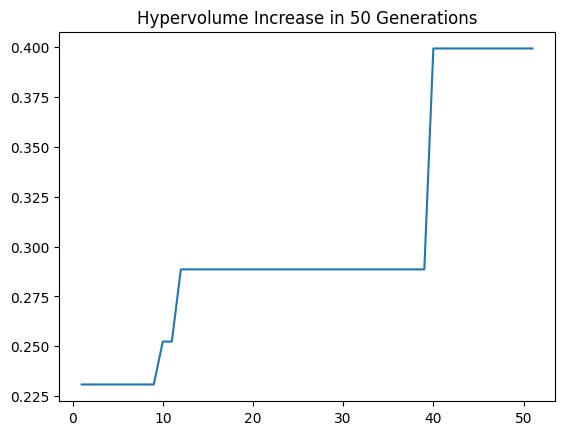

1325

In [92]:
new_dataset,Hypervolume_increse_NSGA = optimize_problem(algorithm_1,algorithm_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.04851075635924838
Iteration : 1 Hypervolume of Non Dominated Front is 0.06343129832813627
Iteration : 2 Hypervolume of Non Dominated Front is 0.06343129832813627
Iteration : 3 Hypervolume of Non Dominated Front is 0.06343129832813627
Iteration : 4 Hypervolume of Non Dominated Front is 0.06787422007575354
Iteration : 5 Hypervolume of Non Dominated Front is 0.06787422007575354
Iteration : 6 Hypervolume of Non Dominated Front is 0.06787422007575354
Iteration : 7 Hypervolume of Non Dominated Front is 0.06787422007575354
Iteration : 8 Hypervolume of Non Dominated Front is 0.06866605707248748
Iteration : 9 Hypervolume of Non Dominated Front is 0.06866605707248748
Iteration : 10 Hypervolume of Non Dominated Front is 0.06866605707248748
Iteration : 11 Hypervolume of Non Dominated Front is 0.06866605707248748
Iteration : 12 Hypervolume of Non Dominated Front is 0.06866605707248748
Iteration : 13 Hypervolume of Non Dominated Front is 0.0740018244164091
Iterat

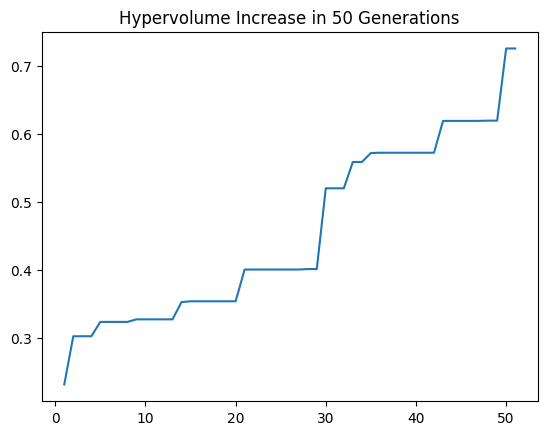

1325

In [93]:
new_dataset,Hypervolume_increse_MOEAD = optimize_problem(algorithm_2_1,algorithm_2_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.04851075635924838
Iteration : 1 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 2 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 3 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 4 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 5 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 6 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 7 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 8 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 9 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 10 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 11 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 12 Hypervolume of Non Dominated Front is 0.04851075635924838
Iteration : 13 Hypervolume of Non Dominated Front is 0.04851075635924838
Itera

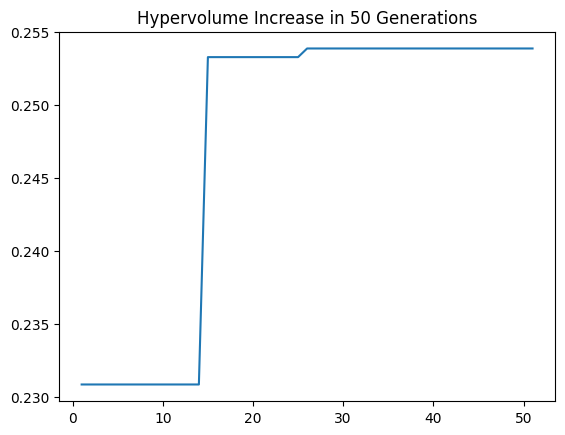

1325

In [94]:
new_dataset,Hypervolume_increse_NSGA3 = optimize_problem(algorithm_3_1,algorithm_3_2,problem_1,problem_2)
len(new_dataset)


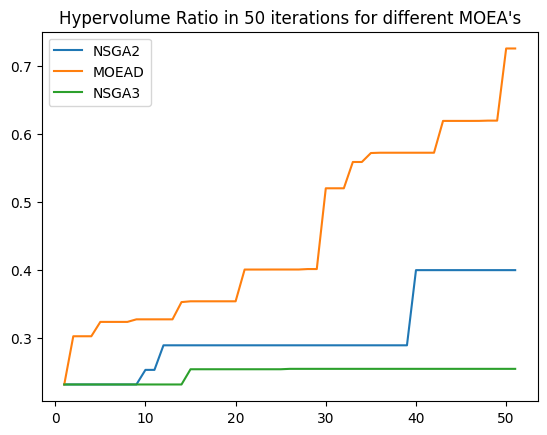

In [95]:
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA,label="NSGA2")
plt.plot(list(range(1,52)),Hypervolume_increse_MOEAD,label="MOEAD")
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA3,label="NSGA3")
plt.title("Hypervolume Ratio in 50 iterations for different MOEA's")
plt.legend()
plt.show()



#### DTLZ2 nobj=2 , nvars = 10

In [101]:
weight_vectors = get_reference_directions('energy',2,100)

In [102]:
problem = DTLZ2(n_obj=2,n_var=10)
sampling  = LHS()
ref_dirs = sampling(problem,100).get('X')

In [103]:
pareto_front = problem.pareto_front()
hypervolume_pf = Hypervolume(pf= pareto_front,norm_ref_point=False).do(pareto_front)
print('Hypervolume of PF is {0} '.format(hypervolume_pf))

[1. 1.]
Hypervolume of PF is 0.2101303514688242 


In [104]:
output = {}
problem._evaluate(ref_dirs,output)

In [105]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
columns = []
for i in range(1,11):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']


In [106]:
dataset.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Objective 1,Objective 2
0,0.539723,0.618745,0.255334,0.991153,0.340642,0.861821,0.574310,0.999303,0.648334,0.905744,1.265686,1.434381
1,0.092082,0.552049,0.231654,0.581550,0.720000,0.011280,0.756569,0.308284,0.725660,0.725614,1.556597,0.226732
2,0.088243,0.291491,0.855145,0.668326,0.002259,0.184125,0.502668,0.115216,0.779092,0.491089,1.754507,0.244765
3,0.551572,0.171325,0.039529,0.177140,0.092018,0.716719,0.645591,0.047284,0.628050,0.787418,1.271093,1.495723
4,0.409421,0.505627,0.047857,0.279843,0.496041,0.625062,0.790128,0.275670,0.109926,0.814046,1.323477,0.991815


##### MOdelling on Objective 1

In [107]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [108]:
kernel_2 = C(4.0) * RBF(length_scale=0.1) + WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

#### Model on Objective 2

In [109]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [110]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=10, n_obj=4,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i]])
        out["F"] = objective_values

In [111]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=10, n_obj=2,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,mean]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i]])
        out["F"] = objective_values

In [112]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm_1,algorithm_2):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm_1,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm_2,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [113]:
# non dominated sorting

def fast_non_dominated_sort(F, **kwargs):
    
    M = Dominator.calc_domination_matrix(F)

    # calculate the dominance matrix
    n = M.shape[0]

    fronts = []

    if n == 0:
        return fronts

    # final rank that will be returned
    n_ranked = 0
    ranked = np.zeros(n, dtype=int)

    # for each individual a list of all individuals that are dominated by this one
    is_dominating = [[] for _ in range(n)]

    # storage for the number of solutions dominated this one
    n_dominated = np.zeros(n)

    current_front = []

    for i in range(n):

        for j in range(i + 1, n):
            rel = M[i, j]
            if rel == 1:
                is_dominating[i].append(j)
                n_dominated[j] += 1
            elif rel == -1:
                is_dominating[j].append(i)
                n_dominated[i] += 1

        if n_dominated[i] == 0:
            current_front.append(i)
            ranked[i] = 1.0
            n_ranked += 1

    # append the first front to the current front
    fronts.append(current_front)

    # while not all solutions are assigned to a pareto front
    while n_ranked < n:

        next_front = []

        # for each individual in the current front
        for i in current_front:

            # all solutions that are dominated by this individuals
            for j in is_dominating[i]:
                n_dominated[j] -= 1
                if n_dominated[j] == 0:
                    next_front.append(j)
                    ranked[j] = 1.0
                    n_ranked += 1

        fronts.append(next_front)
        current_front = next_front

    return fronts

In [114]:
def optimize_problem(algorithm_1,algorithm_2, problem_1,problem_2):
    data = []
    initial_output = {}
    Hypervolume  = []
    new_ref_dirs = ref_dirs
    problem._evaluate(ref_dirs,initial_output)
    initial_objectives = initial_output['F']
    initial_ref_vec  = [1.0,1.0]
    initial_non_dominated_front = fast_non_dominated_sort(initial_objectives)
    initial_ind = HV(ref_point=initial_ref_vec)
    print('Iteration 0 initial Hypervolume is {0}'.format(initial_ind(initial_objectives[initial_non_dominated_front[0]])))
    Hypervolume.append(initial_ind(initial_objectives[initial_non_dominated_front[0]]))
    for i in range(50):
        data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm_1,algorithm_2))
        new_data = list(new_ref_dirs) + data
        new_ref_dirs = list(new_ref_dirs) + data
        new_data = np.array(new_data)
        output = {}
        new_objectives  = problem._evaluate(new_data,output)
        new_dataset = pd.DataFrame(data = new_data,columns = columns)
        new_obj1 = [i[0] for i in output['F']]
        new_obj2 = [i[1] for i in output['F']]
        new_dataset['Objective 1']  = new_obj1
        new_dataset['Objective 2'] = new_obj2
        objectives_new = []
        objectives1_new = list(new_dataset['Objective 1'])
        objectives2_new = list(new_dataset['Objective 2'])
        for j in range(len(new_dataset['Objective 1'])):
            objectives_new.append([objectives1_new[j],objectives2_new[j]])
        #print('Calculating Front')
        fronts_new = fast_non_dominated_sort(np.array(objectives_new))
        ref_vector  = [1.0,1.0] #[max(objectives1_new),max(objectives2_new)]
        objectives  = np.array(objectives_new)
        #print('Calculating Hypervolumne',objectives[fronts_new[0]])
        ind = HV(ref_point=ref_vector)
        Hypervolume.append(ind(objectives[fronts_new[0]]))
        print('Iteration : {0} Hypervolume of Non Dominated Front is {1}'.format(i+1,ind(objectives[fronts_new[0]])))
    Hypervolume_increase = [i/hypervolume_pf for i in Hypervolume]
    plt.plot(list(range(1,52)),Hypervolume_increase)
    plt.title('Hypervolume Increase in 50 Generations')
    plt.show()
    return [new_dataset,Hypervolume_increase]


In [115]:
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm_2 = NSGA2(pop_size = 100)
algorithm_2_2 = MOEAD(ref_dirs=weight_vectors)
algorithm_3_2 = NSGA3(ref_dirs=weight_vectors)

weight_vectors_1 = get_reference_directions('energy',4,100)
algorithm_1 = NSGA2(pop_size = 100)
algorithm_2_1 = MOEAD(ref_dirs=weight_vectors_1)
algorithm_3_1 = NSGA3(ref_dirs=weight_vectors_1)


Iteration 0 initial Hypervolume is 0.0
Iteration : 1 Hypervolume of Non Dominated Front is 0.0
Iteration : 2 Hypervolume of Non Dominated Front is 0.0
Iteration : 3 Hypervolume of Non Dominated Front is 0.0
Iteration : 4 Hypervolume of Non Dominated Front is 0.0
Iteration : 5 Hypervolume of Non Dominated Front is 0.0
Iteration : 6 Hypervolume of Non Dominated Front is 0.0
Iteration : 7 Hypervolume of Non Dominated Front is 0.0
Iteration : 8 Hypervolume of Non Dominated Front is 0.0
Iteration : 9 Hypervolume of Non Dominated Front is 0.0
Iteration : 10 Hypervolume of Non Dominated Front is 0.0
Iteration : 11 Hypervolume of Non Dominated Front is 0.0
Iteration : 12 Hypervolume of Non Dominated Front is 0.0
Iteration : 13 Hypervolume of Non Dominated Front is 0.0
Iteration : 14 Hypervolume of Non Dominated Front is 0.0
Iteration : 15 Hypervolume of Non Dominated Front is 0.0
Iteration : 16 Hypervolume of Non Dominated Front is 0.0
Iteration : 17 Hypervolume of Non Dominated Front is 0.0
I

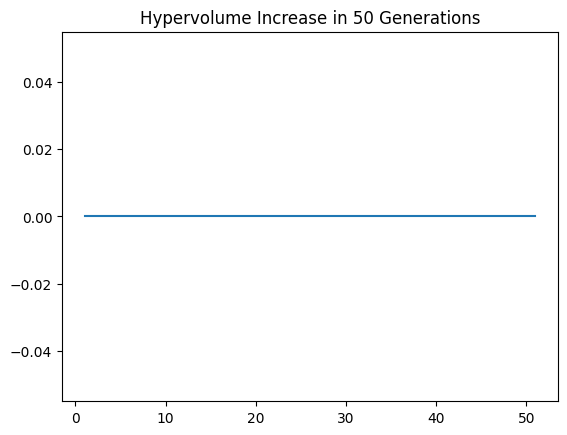

1375

In [121]:
new_dataset,Hypervolume_increse_NSGA = optimize_problem(algorithm_1,algorithm_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.0
Iteration : 1 Hypervolume of Non Dominated Front is 0.0
Iteration : 2 Hypervolume of Non Dominated Front is 0.0
Iteration : 3 Hypervolume of Non Dominated Front is 0.0
Iteration : 4 Hypervolume of Non Dominated Front is 0.0024540872116848036
Iteration : 5 Hypervolume of Non Dominated Front is 0.0024540872116848036
Iteration : 6 Hypervolume of Non Dominated Front is 0.003384860794677545
Iteration : 7 Hypervolume of Non Dominated Front is 0.003384860794677545
Iteration : 8 Hypervolume of Non Dominated Front is 0.003384860794677545
Iteration : 9 Hypervolume of Non Dominated Front is 0.003384860794677545
Iteration : 10 Hypervolume of Non Dominated Front is 0.003384860794677545
Iteration : 11 Hypervolume of Non Dominated Front is 0.003384860794677545
Iteration : 12 Hypervolume of Non Dominated Front is 0.045756925012853736
Iteration : 13 Hypervolume of Non Dominated Front is 0.045756925012853736
Iteration : 14 Hypervolume of Non Dominated Front is 0.04

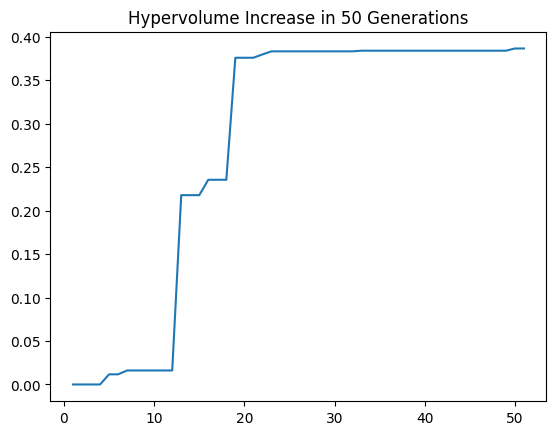

1375

In [117]:
new_dataset,Hypervolume_increse_MOEAD = optimize_problem(algorithm_2_1,algorithm_2_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.0
Iteration : 1 Hypervolume of Non Dominated Front is 0.0
Iteration : 2 Hypervolume of Non Dominated Front is 0.0
Iteration : 3 Hypervolume of Non Dominated Front is 0.0
Iteration : 4 Hypervolume of Non Dominated Front is 0.0
Iteration : 5 Hypervolume of Non Dominated Front is 0.0
Iteration : 6 Hypervolume of Non Dominated Front is 0.0
Iteration : 7 Hypervolume of Non Dominated Front is 0.0
Iteration : 8 Hypervolume of Non Dominated Front is 0.0
Iteration : 9 Hypervolume of Non Dominated Front is 0.0
Iteration : 10 Hypervolume of Non Dominated Front is 0.0
Iteration : 11 Hypervolume of Non Dominated Front is 0.0
Iteration : 12 Hypervolume of Non Dominated Front is 0.0
Iteration : 13 Hypervolume of Non Dominated Front is 0.0
Iteration : 14 Hypervolume of Non Dominated Front is 0.0
Iteration : 15 Hypervolume of Non Dominated Front is 0.0
Iteration : 16 Hypervolume of Non Dominated Front is 0.0
Iteration : 17 Hypervolume of Non Dominated Front is 0.0
I

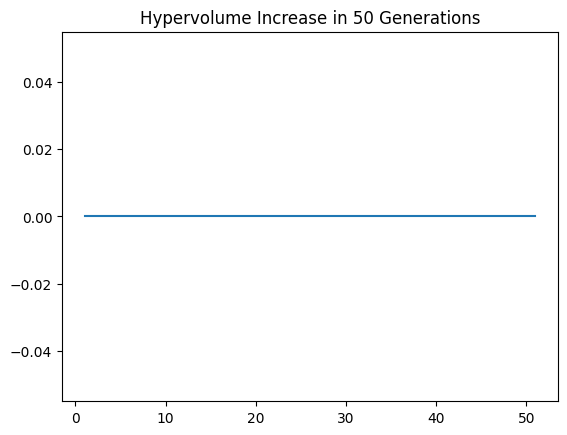

1375

In [120]:
new_dataset,Hypervolume_increse_NSGA3 = optimize_problem(algorithm_3_1,algorithm_3_2,problem_1,problem_2)
len(new_dataset)


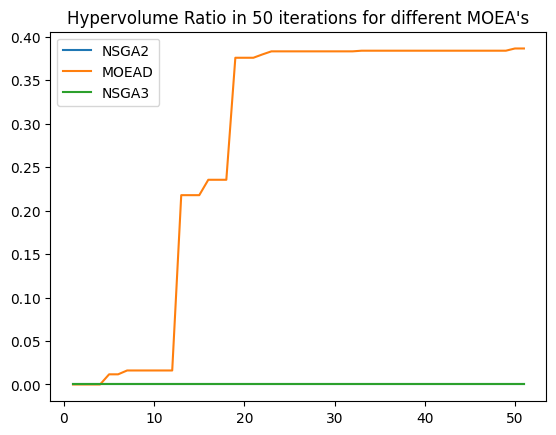

In [122]:
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA,label="NSGA2")
plt.plot(list(range(1,52)),Hypervolume_increse_MOEAD,label="MOEAD")
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA3,label="NSGA3")
plt.title("Hypervolume Ratio in 50 iterations for different MOEA's")
plt.legend()
plt.show()



#### DTLZ2 nobj=3 nvars = 3

In [2]:
weight_vectors = get_reference_directions('energy',3,30)

In [3]:
problem = DTLZ2(n_obj=3,n_var=3)
sampling  = LHS()
ref_dirs = sampling(problem,30).get('X')

In [4]:
pareto_front = problem.pareto_front()
hypervolume_pf = Hypervolume(pf= pareto_front,norm_ref_point=False).do(pareto_front)
print('Hypervolume of PF is {0} '.format(hypervolume_pf))

[1. 1. 1.]
Hypervolume of PF is 0.42576890543289214 


In [5]:
output = {}
problem._evaluate(ref_dirs,output)

In [6]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
objective_value_3 = [i[2] for i in output['F']]
columns = []
for i in range(1,4):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
dataset['Objective 3'] = objective_value_3
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2', 'x3']


In [7]:
dataset.head()

,x1,x2,x3,Objective 1,Objective 2,Objective 3
0,0.238973,0.696690,0.526023,0.426972,0.827318,0.366872
1,0.978226,0.485608,0.194253,0.027031,0.025836,1.092842
2,0.685512,0.417551,0.953436,0.453025,0.348619,1.061468
3,0.618048,0.394146,0.413430,0.463263,0.330115,0.831539
4,0.378167,0.753023,0.268265,0.330324,0.808307,0.589756


##### MOdelling on Objective 1

In [8]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [9]:
kernel_2 = C(4.0) * RBF(length_scale=0.1) + WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Model on Objective 2

In [10]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(4.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Model on Objective 3

In [11]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 3'].to_numpy().reshape(-1,1)
kernel_2 = C(5.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_4 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [12]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=3, n_obj=6,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            #print(value)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            mean_2,std_2 = model_4.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std,mean_2,-std_2]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            mean_2,std_2 = model_4.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i],mean_2[i],-std_2[i]])
        out["F"] = objective_values

In [13]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=3, n_obj=3,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            mean_2,std_2 = model_4.predict(value,return_std=True)
            objective_values = [mean_1,mean,mean_2]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            mean_2,std_2 = model_4.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i],mean_2[i]])
        out["F"] = objective_values

In [14]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm_1,algorithm_2):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm_1,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm_2,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [15]:
# non dominated sorting

def fast_non_dominated_sort(F, **kwargs):
    
    M = Dominator.calc_domination_matrix(F)

    # calculate the dominance matrix
    n = M.shape[0]

    fronts = []

    if n == 0:
        return fronts

    # final rank that will be returned
    n_ranked = 0
    ranked = np.zeros(n, dtype=int)

    # for each individual a list of all individuals that are dominated by this one
    is_dominating = [[] for _ in range(n)]

    # storage for the number of solutions dominated this one
    n_dominated = np.zeros(n)

    current_front = []

    for i in range(n):

        for j in range(i + 1, n):
            rel = M[i, j]
            if rel == 1:
                is_dominating[i].append(j)
                n_dominated[j] += 1
            elif rel == -1:
                is_dominating[j].append(i)
                n_dominated[i] += 1

        if n_dominated[i] == 0:
            current_front.append(i)
            ranked[i] = 1.0
            n_ranked += 1

    # append the first front to the current front
    fronts.append(current_front)

    # while not all solutions are assigned to a pareto front
    while n_ranked < n:

        next_front = []

        # for each individual in the current front
        for i in current_front:

            # all solutions that are dominated by this individuals
            for j in is_dominating[i]:
                n_dominated[j] -= 1
                if n_dominated[j] == 0:
                    next_front.append(j)
                    ranked[j] = 1.0
                    n_ranked += 1

        fronts.append(next_front)
        current_front = next_front

    return fronts

In [16]:
def optimize_problem(algorithm_1,algorithm_2, problem_1,problem_2):
    data = []
    initial_output = {}
    Hypervolume  = []
    new_ref_dirs = ref_dirs
    problem._evaluate(ref_dirs,initial_output)
    initial_objectives = initial_output['F']
    initial_ref_vec  = [1.0,1.0,1.0]
    initial_non_dominated_front = fast_non_dominated_sort(initial_objectives)
    initial_ind = HV(ref_point=initial_ref_vec)
    print('Iteration 0 initial Hypervolume is {0}'.format(initial_ind(initial_objectives[initial_non_dominated_front[0]])))
    Hypervolume.append(initial_ind(initial_objectives[initial_non_dominated_front[0]]))
    for i in range(50):
        data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm_1,algorithm_2))
        new_data = list(new_ref_dirs) + data
        new_ref_dirs = list(new_ref_dirs) + data
        new_data = np.array(new_data)
        output = {}
        new_objectives  = problem._evaluate(new_data,output)
        new_dataset = pd.DataFrame(data = new_data,columns = columns)
        new_obj1 = [i[0] for i in output['F']]
        new_obj2 = [i[1] for i in output['F']]
        new_obj3 = [i[2] for i in output['F']]
        new_dataset['Objective 1']  = new_obj1
        new_dataset['Objective 2'] = new_obj2
        new_dataset['Objective 3'] = new_obj3
        objectives_new = []
        objectives1_new = list(new_dataset['Objective 1'])
        objectives2_new = list(new_dataset['Objective 2'])
        objectives3_new = list(new_dataset['Objective 3'])
        for j in range(len(new_dataset['Objective 1'])):
            objectives_new.append([objectives1_new[j],objectives2_new[j],objectives3_new[j]])
        #print('Calculating Front')
        fronts_new = fast_non_dominated_sort(np.array(objectives_new))
        ref_vector  = [1.0,1.0,1.0] #[max(objectives1_new),max(objectives2_new)]
        objectives  = np.array(objectives_new)
        #print('Calculating Hypervolumne',objectives[fronts_new[0]])
        ind = HV(ref_point=ref_vector)
        Hypervolume.append(ind(objectives[fronts_new[0]]))
        print('Iteration : {0} Hypervolume of Non Dominated Front is {1}'.format(i+1,ind(objectives[fronts_new[0]])))
    Hypervolume_increase = [i/hypervolume_pf for i in Hypervolume]
    plt.plot(list(range(1,52)),Hypervolume_increase)
    plt.title('Hypervolume Increase in 50 Generations')
    plt.show()
    return [new_dataset,Hypervolume_increase]


In [17]:
weight_vectors = get_reference_directions('energy',3,30)
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm_2 = NSGA2(pop_size = 100)
algorithm_2_2 = MOEAD(ref_dirs=weight_vectors)
algorithm_3_2 = NSGA3(ref_dirs=weight_vectors)

weight_vectors_1 = get_reference_directions('energy',6,30)
algorithm_1 = NSGA2(pop_size = 100)
algorithm_2_1 = MOEAD(ref_dirs=weight_vectors_1)
algorithm_3_1 = NSGA3(ref_dirs=weight_vectors_1)


Iteration 0 initial Hypervolume is 0.22846373873355108
Iteration : 1 Hypervolume of Non Dominated Front is 0.24363286522683844
Iteration : 2 Hypervolume of Non Dominated Front is 0.24363286522683844
Iteration : 3 Hypervolume of Non Dominated Front is 0.2522679049486093
Iteration : 4 Hypervolume of Non Dominated Front is 0.2536180066970246
Iteration : 5 Hypervolume of Non Dominated Front is 0.2536180066970246
Iteration : 6 Hypervolume of Non Dominated Front is 0.2536180066970246
Iteration : 7 Hypervolume of Non Dominated Front is 0.2556363284114858
Iteration : 8 Hypervolume of Non Dominated Front is 0.25874634189644596
Iteration : 9 Hypervolume of Non Dominated Front is 0.2600470697535041
Iteration : 10 Hypervolume of Non Dominated Front is 0.2600470697535041
Iteration : 11 Hypervolume of Non Dominated Front is 0.2600470697535041
Iteration : 12 Hypervolume of Non Dominated Front is 0.2600470697535041
Iteration : 13 Hypervolume of Non Dominated Front is 0.26026849361578985
Iteration : 14

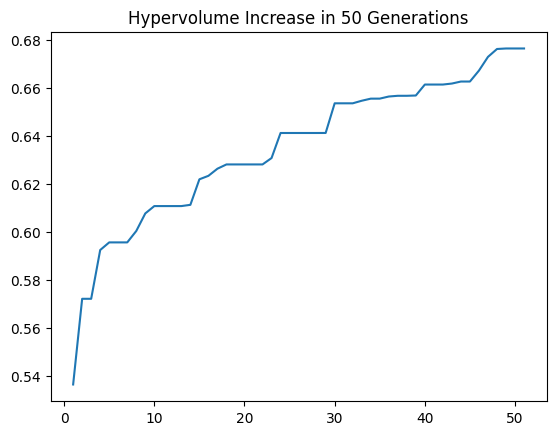

1305

In [18]:
new_dataset,Hypervolume_increse_NSGA = optimize_problem(algorithm_1,algorithm_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.22846373873355108
Iteration : 1 Hypervolume of Non Dominated Front is 0.23856189501269587
Iteration : 2 Hypervolume of Non Dominated Front is 0.24485461812869713
Iteration : 3 Hypervolume of Non Dominated Front is 0.24807979114127024
Iteration : 4 Hypervolume of Non Dominated Front is 0.24850172791263475
Iteration : 5 Hypervolume of Non Dominated Front is 0.26049253406158845
Iteration : 6 Hypervolume of Non Dominated Front is 0.26088378471069007
Iteration : 7 Hypervolume of Non Dominated Front is 0.26088378471069007
Iteration : 8 Hypervolume of Non Dominated Front is 0.26088378471069007
Iteration : 9 Hypervolume of Non Dominated Front is 0.2615699299158714
Iteration : 10 Hypervolume of Non Dominated Front is 0.2620913294027118
Iteration : 11 Hypervolume of Non Dominated Front is 0.2633942294819219
Iteration : 12 Hypervolume of Non Dominated Front is 0.28833237941350315
Iteration : 13 Hypervolume of Non Dominated Front is 0.28833389955890315
Iteratio

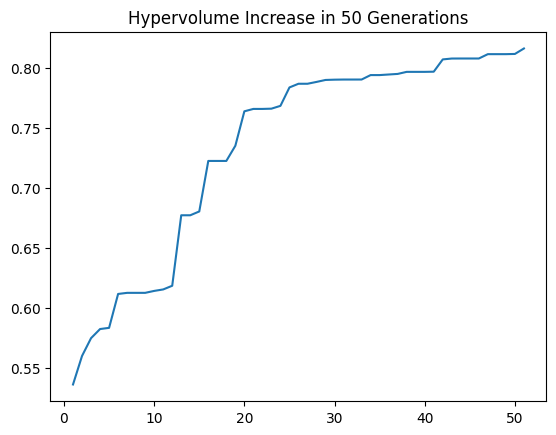

1305

In [19]:
new_dataset,Hypervolume_increse_MOEAD = optimize_problem(algorithm_2_1,algorithm_2_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.22846373873355108
Iteration : 1 Hypervolume of Non Dominated Front is 0.23367150375785872
Iteration : 2 Hypervolume of Non Dominated Front is 0.24012546790876876
Iteration : 3 Hypervolume of Non Dominated Front is 0.24049733986206207
Iteration : 4 Hypervolume of Non Dominated Front is 0.24049733986206207
Iteration : 5 Hypervolume of Non Dominated Front is 0.2433524937621595
Iteration : 6 Hypervolume of Non Dominated Front is 0.2437627860925048
Iteration : 7 Hypervolume of Non Dominated Front is 0.24581442058794556
Iteration : 8 Hypervolume of Non Dominated Front is 0.2460639887940352
Iteration : 9 Hypervolume of Non Dominated Front is 0.2460639887940352
Iteration : 10 Hypervolume of Non Dominated Front is 0.2460639887940352
Iteration : 11 Hypervolume of Non Dominated Front is 0.2460639887940352
Iteration : 12 Hypervolume of Non Dominated Front is 0.24991538988770864
Iteration : 13 Hypervolume of Non Dominated Front is 0.24991538988770864
Iteration :

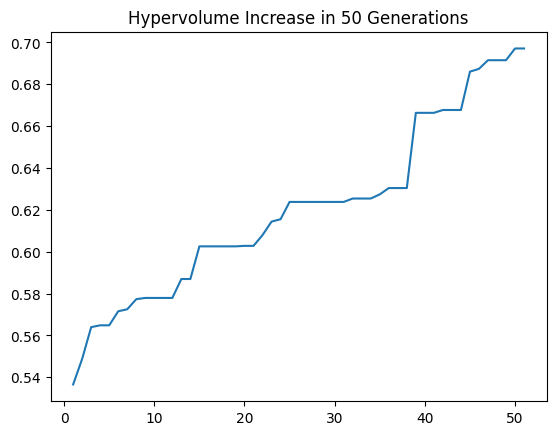

1305

In [20]:
new_dataset,Hypervolume_increse_NSGA3 = optimize_problem(algorithm_3_1,algorithm_3_2,problem_1,problem_2)
len(new_dataset)


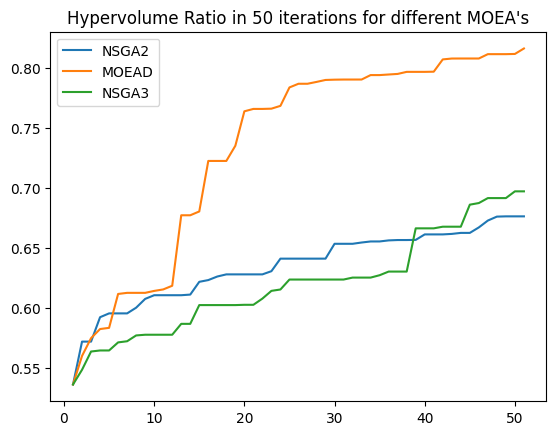

In [22]:
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA,label="NSGA2")
plt.plot(list(range(1,52)),Hypervolume_increse_MOEAD,label="MOEAD")
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA3,label="NSGA3")
plt.title("Hypervolume Ratio in 50 iterations for different MOEA's")
plt.legend()
plt.show()



#### DTLZ2 nobj = 3 , nvars = 5

In [23]:
weight_vectors = get_reference_directions('energy',3,30)

In [24]:
problem = DTLZ2(n_obj=3,n_var=5)
sampling  = LHS()
ref_dirs = sampling(problem,30).get('X')

In [25]:
pareto_front = problem.pareto_front()
hypervolume_pf = Hypervolume(pf= pareto_front,norm_ref_point=False).do(pareto_front)
print('Hypervolume of PF is {0} '.format(hypervolume_pf))

[1. 1. 1.]
Hypervolume of PF is 0.42576890543289214 


In [26]:
output = {}
problem._evaluate(ref_dirs,output)

In [27]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
objective_value_3 = [i[2] for i in output['F']]
columns = []
for i in range(1,6):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
dataset['Objective 3'] = objective_value_3
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2', 'x3', 'x4', 'x5']


In [28]:
dataset.head()

,x1,x2,x3,x4,x5,Objective 1,Objective 2,Objective 3
0,0.609644,0.687590,0.328566,0.469061,0.245793,0.296954,0.555752,0.895496
1,0.229093,0.454296,0.654106,0.285900,0.837854,0.837587,0.725198,0.416842
2,0.508922,0.957011,0.516366,0.129870,0.304850,0.055288,0.817500,0.842663
3,0.335480,0.064809,0.952163,0.682373,0.998767,1.278164,0.130571,0.747577
4,0.861530,0.400939,0.108962,0.323399,0.532655,0.206688,0.150634,1.157241


##### MOdelling on Objective 1

In [29]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [30]:
kernel_2 = C(4.0) * RBF(length_scale=0.1) + WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

#### Model on Objective 2

In [31]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(4.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

#### Model on Objective 3

In [32]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 3'].to_numpy().reshape(-1,1)
kernel_2 = C(5.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_4 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [33]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=5, n_obj=6,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            #print(value)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            mean_2,std_2 = model_4.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std,mean_2,-std_2]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            mean_2,std_2 = model_4.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i],mean_2[i],-std_2[i]])
        out["F"] = objective_values

In [34]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=5, n_obj=3,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            mean_2,std_2 = model_4.predict(value,return_std=True)
            objective_values = [mean_1,mean,mean_2]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            mean_2,std_2 = model_4.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i],mean_2[i]])
        out["F"] = objective_values

In [35]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm_1,algorithm_2):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm_1,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm_2,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [36]:
# non dominated sorting

def fast_non_dominated_sort(F, **kwargs):
    
    M = Dominator.calc_domination_matrix(F)

    # calculate the dominance matrix
    n = M.shape[0]

    fronts = []

    if n == 0:
        return fronts

    # final rank that will be returned
    n_ranked = 0
    ranked = np.zeros(n, dtype=int)

    # for each individual a list of all individuals that are dominated by this one
    is_dominating = [[] for _ in range(n)]

    # storage for the number of solutions dominated this one
    n_dominated = np.zeros(n)

    current_front = []

    for i in range(n):

        for j in range(i + 1, n):
            rel = M[i, j]
            if rel == 1:
                is_dominating[i].append(j)
                n_dominated[j] += 1
            elif rel == -1:
                is_dominating[j].append(i)
                n_dominated[i] += 1

        if n_dominated[i] == 0:
            current_front.append(i)
            ranked[i] = 1.0
            n_ranked += 1

    # append the first front to the current front
    fronts.append(current_front)

    # while not all solutions are assigned to a pareto front
    while n_ranked < n:

        next_front = []

        # for each individual in the current front
        for i in current_front:

            # all solutions that are dominated by this individuals
            for j in is_dominating[i]:
                n_dominated[j] -= 1
                if n_dominated[j] == 0:
                    next_front.append(j)
                    ranked[j] = 1.0
                    n_ranked += 1

        fronts.append(next_front)
        current_front = next_front

    return fronts

In [37]:
def optimize_problem(algorithm_1,algorithm_2, problem_1,problem_2):
    data = []
    initial_output = {}
    Hypervolume  = []
    new_ref_dirs = ref_dirs
    problem._evaluate(ref_dirs,initial_output)
    initial_objectives = initial_output['F']
    initial_ref_vec  = [1.0,1.0,1.0]
    initial_non_dominated_front = fast_non_dominated_sort(initial_objectives)
    initial_ind = HV(ref_point=initial_ref_vec)
    print('Iteration 0 initial Hypervolume is {0}'.format(initial_ind(initial_objectives[initial_non_dominated_front[0]])))
    Hypervolume.append(initial_ind(initial_objectives[initial_non_dominated_front[0]]))
    for i in range(50):
        data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm_1,algorithm_2))
        new_data = list(new_ref_dirs) + data
        new_ref_dirs = list(new_ref_dirs) + data
        new_data = np.array(new_data)
        output = {}
        new_objectives  = problem._evaluate(new_data,output)
        new_dataset = pd.DataFrame(data = new_data,columns = columns)
        new_obj1 = [i[0] for i in output['F']]
        new_obj2 = [i[1] for i in output['F']]
        new_obj3 = [i[2] for i in output['F']]
        new_dataset['Objective 1']  = new_obj1
        new_dataset['Objective 2'] = new_obj2
        new_dataset['Objective 3'] = new_obj3
        objectives_new = []
        objectives1_new = list(new_dataset['Objective 1'])
        objectives2_new = list(new_dataset['Objective 2'])
        objectives3_new = list(new_dataset['Objective 3'])
        for j in range(len(new_dataset['Objective 1'])):
            objectives_new.append([objectives1_new[j],objectives2_new[j],objectives3_new[j]])
        #print('Calculating Front')
        fronts_new = fast_non_dominated_sort(np.array(objectives_new))
        ref_vector  = [1.0,1.0,1.0] #[max(objectives1_new),max(objectives2_new)]
        objectives  = np.array(objectives_new)
        #print('Calculating Hypervolumne',objectives[fronts_new[0]])
        ind = HV(ref_point=ref_vector)
        Hypervolume.append(ind(objectives[fronts_new[0]]))
        print('Iteration : {0} Hypervolume of Non Dominated Front is {1}'.format(i+1,ind(objectives[fronts_new[0]])))
    Hypervolume_increase = [i/hypervolume_pf for i in Hypervolume]
    plt.plot(list(range(1,52)),Hypervolume_increase)
    plt.title('Hypervolume Increase in 50 Generations')
    plt.show()
    return [new_dataset,Hypervolume_increase]


In [38]:
weight_vectors = get_reference_directions('energy',3,30)
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm_2 = NSGA2(pop_size = 100)
algorithm_2_2 = MOEAD(ref_dirs=weight_vectors)
algorithm_3_2 = NSGA3(ref_dirs=weight_vectors)

weight_vectors_1 = get_reference_directions('energy',6,30)
algorithm_1 = NSGA2(pop_size = 100)
algorithm_2_1 = MOEAD(ref_dirs=weight_vectors_1)
algorithm_3_1 = NSGA3(ref_dirs=weight_vectors_1)


Iteration 0 initial Hypervolume is 0.1420692744114645
Iteration : 1 Hypervolume of Non Dominated Front is 0.14324439454240548
Iteration : 2 Hypervolume of Non Dominated Front is 0.14324439454240548
Iteration : 3 Hypervolume of Non Dominated Front is 0.14324439454240548
Iteration : 4 Hypervolume of Non Dominated Front is 0.14324439454240548
Iteration : 5 Hypervolume of Non Dominated Front is 0.14324439454240548
Iteration : 6 Hypervolume of Non Dominated Front is 0.14324439454240548
Iteration : 7 Hypervolume of Non Dominated Front is 0.14324439454240548
Iteration : 8 Hypervolume of Non Dominated Front is 0.15549106794698053
Iteration : 9 Hypervolume of Non Dominated Front is 0.16598415409953743
Iteration : 10 Hypervolume of Non Dominated Front is 0.17202299541350444
Iteration : 11 Hypervolume of Non Dominated Front is 0.17202299541350444
Iteration : 12 Hypervolume of Non Dominated Front is 0.17302646265537705
Iteration : 13 Hypervolume of Non Dominated Front is 0.17302646265537705
Iterat

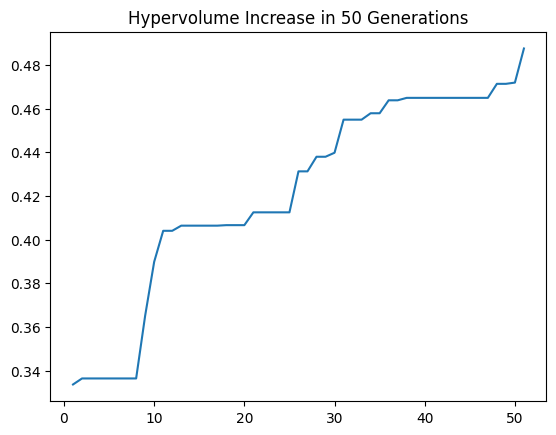

1305

In [39]:
new_dataset,Hypervolume_increse_NSGA = optimize_problem(algorithm_1,algorithm_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.1420692744114645
Iteration : 1 Hypervolume of Non Dominated Front is 0.15634189301507548
Iteration : 2 Hypervolume of Non Dominated Front is 0.16982499823977007
Iteration : 3 Hypervolume of Non Dominated Front is 0.16982499823977007
Iteration : 4 Hypervolume of Non Dominated Front is 0.16982499823977007
Iteration : 5 Hypervolume of Non Dominated Front is 0.17076317675899028
Iteration : 6 Hypervolume of Non Dominated Front is 0.1728629264278683
Iteration : 7 Hypervolume of Non Dominated Front is 0.1769101191170033
Iteration : 8 Hypervolume of Non Dominated Front is 0.1769101191170033
Iteration : 9 Hypervolume of Non Dominated Front is 0.1769101191170033
Iteration : 10 Hypervolume of Non Dominated Front is 0.1769101191170033
Iteration : 11 Hypervolume of Non Dominated Front is 0.1769101191170033
Iteration : 12 Hypervolume of Non Dominated Front is 0.17838932276579272
Iteration : 13 Hypervolume of Non Dominated Front is 0.18137256036541458
Iteration : 

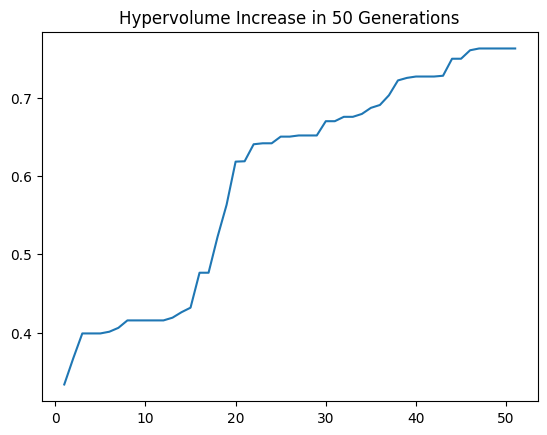

1305

In [40]:
new_dataset,Hypervolume_increse_MOEAD = optimize_problem(algorithm_2_1,algorithm_2_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.1420692744114645
Iteration : 1 Hypervolume of Non Dominated Front is 0.1420692744114645
Iteration : 2 Hypervolume of Non Dominated Front is 0.1420692744114645
Iteration : 3 Hypervolume of Non Dominated Front is 0.1420692744114645
Iteration : 4 Hypervolume of Non Dominated Front is 0.1420692744114645
Iteration : 5 Hypervolume of Non Dominated Front is 0.1420692744114645
Iteration : 6 Hypervolume of Non Dominated Front is 0.14214461591978605
Iteration : 7 Hypervolume of Non Dominated Front is 0.14214461591978605
Iteration : 8 Hypervolume of Non Dominated Front is 0.14214461591978605
Iteration : 9 Hypervolume of Non Dominated Front is 0.14214461591978605
Iteration : 10 Hypervolume of Non Dominated Front is 0.14214461591978605
Iteration : 11 Hypervolume of Non Dominated Front is 0.14214461591978605
Iteration : 12 Hypervolume of Non Dominated Front is 0.14214461591978605
Iteration : 13 Hypervolume of Non Dominated Front is 0.14214461591978605
Iteration :

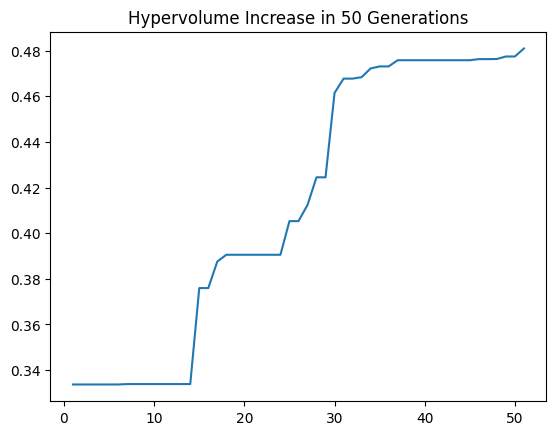

1305

In [41]:
new_dataset,Hypervolume_increse_NSGA3 = optimize_problem(algorithm_3_1,algorithm_3_2,problem_1,problem_2)
len(new_dataset)


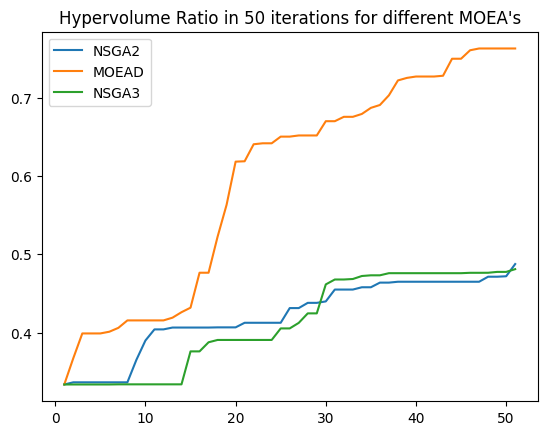

In [42]:
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA,label="NSGA2")
plt.plot(list(range(1,52)),Hypervolume_increse_MOEAD,label="MOEAD")
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA3,label="NSGA3")
plt.title("Hypervolume Ratio in 50 iterations for different MOEA's")
plt.legend()
plt.show()



#### DTLZ2 nobj =3 and nvars = 10

In [43]:
weight_vectors = get_reference_directions('energy',3,100)

In [44]:
problem = DTLZ2(n_obj=3,n_var=10)
sampling  = LHS()
ref_dirs = sampling(problem,100).get('X')

In [45]:
pareto_front = problem.pareto_front()
hypervolume_pf = Hypervolume(pf= pareto_front,norm_ref_point=False).do(pareto_front)
print('Hypervolume of PF is {0} '.format(hypervolume_pf))

[1. 1. 1.]
Hypervolume of PF is 0.42576890543289214 


In [46]:
output = {}
problem._evaluate(ref_dirs,output)

In [47]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
objective_value_3 = [i[2] for i in output['F']]
columns = []
for i in range(1,11):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
dataset['Objective 3'] = objective_value_3
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']


In [48]:
dataset.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Objective 1,Objective 2,Objective 3
0,0.759925,0.028795,0.641295,0.958480,0.374936,0.840663,0.291635,0.184888,0.907197,0.273020,0.633415,0.028670,1.600908
1,0.184753,0.589329,0.902444,0.430787,0.666192,0.021195,0.616738,0.658233,0.870151,0.658574,0.935877,1.243740,0.464841
2,0.572716,0.210738,0.195667,0.277969,0.518290,0.430770,0.683544,0.101314,0.990174,0.282809,0.956984,0.328889,1.274186
3,0.269415,0.463519,0.185615,0.760144,0.572047,0.574232,0.009871,0.476330,0.699151,0.189686,1.057612,0.942853,0.638173
4,0.133526,0.679948,0.351546,0.534709,0.969207,0.147605,0.677394,0.136729,0.757347,0.243843,0.783649,1.425175,0.346221


##### MOdelling on Objective 1

In [49]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [50]:
kernel_2 = C(4.0) * RBF(length_scale=0.1) + WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

#### Model on Objective 2

In [51]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(4.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

#### Model on Objective 3

In [52]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 3'].to_numpy().reshape(-1,1)
kernel_2 = C(5.0) * RBF(length_scale=0.1) +  WhiteKernel()
#kernel =  RBF(length_scale=3) 
model_4 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=12).fit(X,Y)

#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [53]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=10, n_obj=6,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            #print(value)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            mean_2,std_2 = model_4.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std,mean_2,-std_2]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            mean_2,std_2 = model_4.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i],mean_2[i],-std_2[i]])
        out["F"] = objective_values

In [54]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=10, n_obj=3,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            mean_2,std_2 = model_4.predict(value,return_std=True)
            objective_values = [mean_1,mean,mean_2]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            mean_2,std_2 = model_4.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i],mean_2[i]])
        out["F"] = objective_values

In [55]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm_1,algorithm_2):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm_1,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm_2,
                ('n_gen', 200),
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [56]:
# non dominated sorting

def fast_non_dominated_sort(F, **kwargs):
    
    M = Dominator.calc_domination_matrix(F)

    # calculate the dominance matrix
    n = M.shape[0]

    fronts = []

    if n == 0:
        return fronts

    # final rank that will be returned
    n_ranked = 0
    ranked = np.zeros(n, dtype=int)

    # for each individual a list of all individuals that are dominated by this one
    is_dominating = [[] for _ in range(n)]

    # storage for the number of solutions dominated this one
    n_dominated = np.zeros(n)

    current_front = []

    for i in range(n):

        for j in range(i + 1, n):
            rel = M[i, j]
            if rel == 1:
                is_dominating[i].append(j)
                n_dominated[j] += 1
            elif rel == -1:
                is_dominating[j].append(i)
                n_dominated[i] += 1

        if n_dominated[i] == 0:
            current_front.append(i)
            ranked[i] = 1.0
            n_ranked += 1

    # append the first front to the current front
    fronts.append(current_front)

    # while not all solutions are assigned to a pareto front
    while n_ranked < n:

        next_front = []

        # for each individual in the current front
        for i in current_front:

            # all solutions that are dominated by this individuals
            for j in is_dominating[i]:
                n_dominated[j] -= 1
                if n_dominated[j] == 0:
                    next_front.append(j)
                    ranked[j] = 1.0
                    n_ranked += 1

        fronts.append(next_front)
        current_front = next_front

    return fronts

In [57]:
def optimize_problem(algorithm_1,algorithm_2, problem_1,problem_2):
    data = []
    initial_output = {}
    Hypervolume  = []
    new_ref_dirs = ref_dirs
    problem._evaluate(ref_dirs,initial_output)
    initial_objectives = initial_output['F']
    initial_ref_vec  = [1.0,1.0,1.0]
    initial_non_dominated_front = fast_non_dominated_sort(initial_objectives)
    initial_ind = HV(ref_point=initial_ref_vec)
    print('Iteration 0 initial Hypervolume is {0}'.format(initial_ind(initial_objectives[initial_non_dominated_front[0]])))
    Hypervolume.append(initial_ind(initial_objectives[initial_non_dominated_front[0]]))
    for i in range(50):
        data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm_1,algorithm_2))
        new_data = list(new_ref_dirs) + data
        new_ref_dirs = list(new_ref_dirs) + data
        new_data = np.array(new_data)
        output = {}
        new_objectives  = problem._evaluate(new_data,output)
        new_dataset = pd.DataFrame(data = new_data,columns = columns)
        new_obj1 = [i[0] for i in output['F']]
        new_obj2 = [i[1] for i in output['F']]
        new_obj3 = [i[2] for i in output['F']]
        new_dataset['Objective 1']  = new_obj1
        new_dataset['Objective 2'] = new_obj2
        new_dataset['Objective 3'] = new_obj3
        objectives_new = []
        objectives1_new = list(new_dataset['Objective 1'])
        objectives2_new = list(new_dataset['Objective 2'])
        objectives3_new = list(new_dataset['Objective 3'])
        for j in range(len(new_dataset['Objective 1'])):
            objectives_new.append([objectives1_new[j],objectives2_new[j],objectives3_new[j]])
        #print('Calculating Front')
        fronts_new = fast_non_dominated_sort(np.array(objectives_new))
        ref_vector  = [1.0,1.0,1.0] #[max(objectives1_new),max(objectives2_new)]
        objectives  = np.array(objectives_new)
        #print('Calculating Hypervolumne',objectives[fronts_new[0]])
        ind = HV(ref_point=ref_vector)
        Hypervolume.append(ind(objectives[fronts_new[0]]))
        print('Iteration : {0} Hypervolume of Non Dominated Front is {1}'.format(i+1,ind(objectives[fronts_new[0]])))
    Hypervolume_increase = [i/hypervolume_pf for i in Hypervolume]
    plt.plot(list(range(1,52)),Hypervolume_increase)
    plt.title('Hypervolume Increase in 50 Generations')
    plt.show()
    return [new_dataset,Hypervolume_increase]


In [58]:
weight_vectors = get_reference_directions('energy',3,100)
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm_2 = NSGA2(pop_size = 100)
algorithm_2_2 = MOEAD(ref_dirs=weight_vectors)
algorithm_3_2 = NSGA3(ref_dirs=weight_vectors)

weight_vectors_1 = get_reference_directions('energy',6,100)
algorithm_1 = NSGA2(pop_size = 100)
algorithm_2_1 = MOEAD(ref_dirs=weight_vectors_1)
algorithm_3_1 = NSGA3(ref_dirs=weight_vectors_1)


Iteration 0 initial Hypervolume is 0.029917577465944166
Iteration : 1 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 2 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 3 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 4 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 5 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 6 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 7 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 8 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 9 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 10 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 11 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 12 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 13 Hypervolume of Non Dominated Front is 0.0299175774

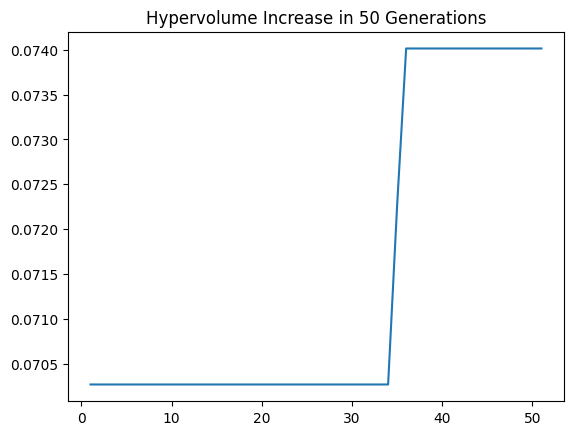

1375

In [59]:
new_dataset,Hypervolume_increse_NSGA = optimize_problem(algorithm_1,algorithm_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.029917577465944166
Iteration : 1 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 2 Hypervolume of Non Dominated Front is 0.07915749203861558
Iteration : 3 Hypervolume of Non Dominated Front is 0.07915749203861558
Iteration : 4 Hypervolume of Non Dominated Front is 0.07915749203861558
Iteration : 5 Hypervolume of Non Dominated Front is 0.0886642785555715
Iteration : 6 Hypervolume of Non Dominated Front is 0.09657491488084255
Iteration : 7 Hypervolume of Non Dominated Front is 0.11649698032149991
Iteration : 8 Hypervolume of Non Dominated Front is 0.143289390132465
Iteration : 9 Hypervolume of Non Dominated Front is 0.143289390132465
Iteration : 10 Hypervolume of Non Dominated Front is 0.16675830810697784
Iteration : 11 Hypervolume of Non Dominated Front is 0.16675830810697784
Iteration : 12 Hypervolume of Non Dominated Front is 0.17759081319826875
Iteration : 13 Hypervolume of Non Dominated Front is 0.17759081319826875
Iteratio

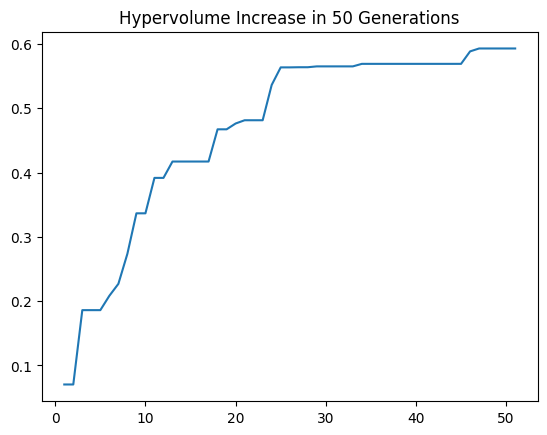

1375

In [60]:
new_dataset,Hypervolume_increse_MOEAD = optimize_problem(algorithm_2_1,algorithm_2_2,problem_1,problem_2)
len(new_dataset)


Iteration 0 initial Hypervolume is 0.029917577465944166
Iteration : 1 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 2 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 3 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 4 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 5 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 6 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 7 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 8 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 9 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 10 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 11 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 12 Hypervolume of Non Dominated Front is 0.029917577465944166
Iteration : 13 Hypervolume of Non Dominated Front is 0.0299175774

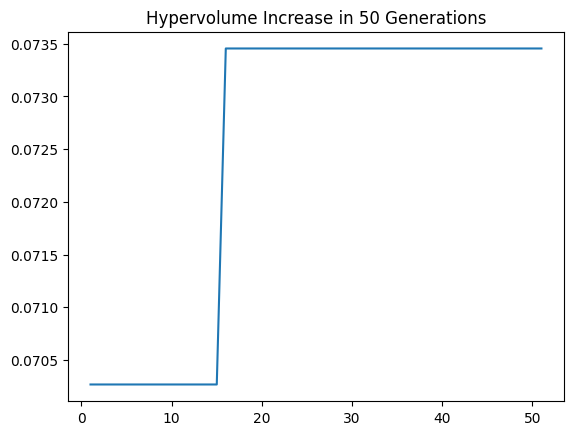

1375

In [61]:
new_dataset,Hypervolume_increse_NSGA3 = optimize_problem(algorithm_3_1,algorithm_3_2,problem_1,problem_2)
len(new_dataset)


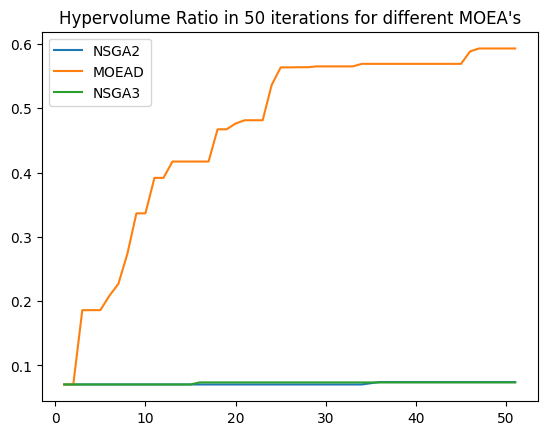

In [62]:
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA,label="NSGA2")
plt.plot(list(range(1,52)),Hypervolume_increse_MOEAD,label="MOEAD")
plt.plot(list(range(1,52)),Hypervolume_increse_NSGA3,label="NSGA3")
plt.title("Hypervolume Ratio in 50 iterations for different MOEA's")
plt.legend()
plt.show()

